In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/powerlifting-benchpress-weight-predict/y_test.csv
/kaggle/input/powerlifting-benchpress-weight-predict/X_test.csv
/kaggle/input/powerlifting-benchpress-weight-predict/y_train.csv
/kaggle/input/powerlifting-benchpress-weight-predict/X_train.csv


# Table of Contents
* [Powerlifting Dataset](#intro)

* [Data Loading and Exploration](#loading)

* [Training](#training)

    - [Split](#split)
    
    - [Cross Validation](#cross_val)
    
    - [R2 Score](#r2)
     

<a id = "intro" ></a>
# Powerlifting Dataset

**Here we have a dataset that contains the Bench Press PB as well as other type of data for multiple individual.**

**The task is to predict what someone's best bench press weight will be.**

**This is a regression problem.**

In [2]:
 %config Completer.use_jedi = False


<a id="loading"></a>
# Data Loading and Exploration

In [3]:
y_test = pd.read_csv('/kaggle/input/powerlifting-benchpress-weight-predict/y_test.csv')
X_test = pd.read_csv('/kaggle/input/powerlifting-benchpress-weight-predict/X_test.csv')
y_train = pd.read_csv('/kaggle/input/powerlifting-benchpress-weight-predict/y_train.csv')
X_train = pd.read_csv('/kaggle/input/powerlifting-benchpress-weight-predict/X_train.csv')

In [4]:
y_test.head()


,playerId,BestBenchKg,Age,BodyweightKg,BestDeadliftKg
0,2308.0,97.52,NaN,NaN,NaN
1,22404.0,75.00,NaN,NaN,NaN
2,23397.0,190.00,NaN,NaN,NaN
3,25058.0,117.50,NaN,NaN,NaN
4,2664.0,145.01,NaN,NaN,NaN


In [5]:
X_test.head()


,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
0,2308.0,Peter Neeves,M,Wraps,30.0,89.81,179.17,192.78
1,22404.0,Josh Padilla,M,Raw,27.0,74.95,125.00,165.00
2,23397.0,Luke Dreier,M,Wraps,30.0,122.61,290.00,317.50
3,25058.0,Jacob New,M,Raw,20.0,88.00,187.50,240.00
4,2664.0,Jesse Burdick,M,Wraps,30.0,122.00,235.01,275.01


In [6]:
y_train.head()


,playerId,BestBenchKg
0,19391.0,125.0
1,15978.0,157.5
2,27209.0,145.0
3,27496.0,60.0
4,20293.0,60.0


In [7]:


X_train.head()

,playerId,Name,Sex,Equipment,Age,BodyweightKg,BestSquatKg,BestDeadliftKg
0,19391.0,Carlos Ceron,M,Raw,23.0,87.30,205.0,235.0
1,15978.0,Tito Herrera,M,Wraps,23.0,73.48,220.0,260.0
2,27209.0,Levi Lehman,M,Raw,26.0,112.40,142.5,220.0
3,27496.0,Stacy Hayford,F,Raw,35.0,59.42,95.0,102.5
4,20293.0,Brittany Hirt,F,Raw,26.5,61.40,105.0,127.5


**We can see that we have several categorical features : "Sex" and "Equipement"**

In [8]:
y_test = y_test.set_index('playerId')
X_test = X_test.set_index('playerId')
y_train = y_train.set_index('playerId')
X_train = X_train.set_index('playerId')

y_test = y_test.drop(['Age','BodyweightKg', 'BestDeadliftKg'], axis= 1)

X_test = X_test.drop(['Name'], axis= 1)
X_train = X_train.drop(['Name'], axis= 1)


In [9]:
X = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])

In [10]:
X.isna().sum()

Sex                 0
Equipment           0
Age               420
BodyweightKg        0
BestSquatKg         0
BestDeadliftKg      0
dtype: int64

In [11]:
y.isna().sum()

BestBenchKg    0
dtype: int64

**There are missing values in the Age columnn, we will have to decide what strategy to use so that our prediction is accurate**

**Some statistics :**

In [12]:
X.describe()

,Age,BodyweightKg,BestDeadliftKg
count,29580.000000,30000.000000,30000.000000
mean,29.678786,85.359097,201.114296
std,11.576102,22.881926,62.369995
min,7.000000,24.100000,18.100000
25%,21.500000,68.050000,147.500000
50%,26.500000,82.100000,204.120000
75%,35.000000,98.880000,247.500000
max,89.500000,242.400000,420.500000


In [13]:
y.describe()

,BestBenchKg
count,30000.000000
mean,116.507738
std,52.355810
min,-280.000000
25%,72.500000
50%,115.000000
75%,150.000000
max,425.000000


In [14]:
print(y.loc[y['BestBenchKg']<0])

          BestBenchKg
playerId             
13064.0       -142.50
26847.0       -227.50
16497.0       -145.00
16983.0       -150.00
24191.0       -110.00
25046.0        -55.00
21040.0       -132.50
17714.0       -160.00
4867.0        -107.50
25982.0        -87.50
13522.0        -55.00
11150.0       -125.00
3222.0         -77.50
8889.0         -60.00
16556.0        -47.50
9266.0         -50.00
4749.0        -135.00
24470.0       -140.00
14724.0        -77.50
11400.0        -55.00
18065.0       -115.00
10229.0        -83.91
18353.0        -80.00
22670.0       -215.00
5035.0        -130.00
25322.0       -137.50
14066.0       -147.50
1371.0        -280.00
9542.0         -70.00
23831.0       -150.00
28183.0       -187.50
17083.0        -57.50
22023.0       -112.50
12291.0       -137.50
18488.0        -47.50
26080.0        -55.00
22820.0        -60.00
7168.0         -62.50
23632.0       -237.50
22017.0       -172.50
8993.0         -45.00
23368.0       -150.00
2879.0        -150.00
17992.0   

**Some values are negative in the target, maybe we can try to turn them positive.**

In [15]:
y['BestBenchKg'] =  y.BestBenchKg.map(lambda x: -x if(x<0) else x)


<a id = "training"></a>
# Training and Evalutation

<a id = "split"></a>

# Split

In [16]:
X['Equipment']

playerId
19391.0      Raw
15978.0    Wraps
27209.0      Raw
27496.0      Raw
20293.0      Raw
           ...  
3104.0     Wraps
10239.0      Raw
29044.0      Raw
29947.0    Wraps
1647.0       Raw
Name: Equipment, Length: 30000, dtype: object

In [17]:
#X contains values that are mistyped floats like 104..5 so we use a regex to replace the two points
X['BestSquatKg'] = X.BestSquatKg.astype('str')
X['BestSquatKg'] = X.BestSquatKg.replace(to_replace='\..{1}', value='.', regex=True)
X['Sex'] = X.Sex.astype('category')
X['Equipment'] = X['Equipment'].astype('category')
X['BestSquatKg'] = X.BestSquatKg.astype('float')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<a id = "cross_val"></a>

# Cross Validation

In [19]:
from lightgbm import LGBMRegressor
from lightgbm import cv
from lightgbm import Dataset

lgbm = LGBMRegressor(objective='regression', random_state=0)
lgbm.fit(X_train, y_train)
test_dataset = Dataset(X_test, y_test, feature_name = "auto")
res = cv( 
        params = {'objective': 'regression'},
        train_set = test_dataset,
        num_boost_round=100,
        nfold=5,
        metrics='mean_squared_error',
        stratified=False)

print(res)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data

<a id = "r2"></a>

# R2 score

**From the MSE we can get the R2 score with the formula R2 = 1-(MSE/Var(y))**

In [20]:
y_arr = np.array(y_test.values)
R2  = 1-(res['l2-mean'][-1]/np.var(y_arr))

In [21]:
print(" R2 score:  {}".format(R2))


 R2 score:  0.8784009700502987


**We get a very good R2 score with the LGBM Regressor**

<a id = "Plot"></a>
# Plot

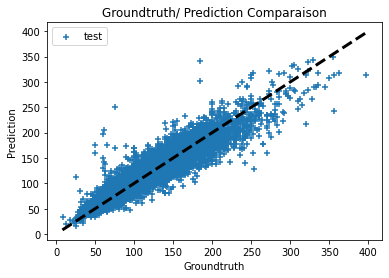

In [22]:
y_test_pred = lgbm.predict(X_test)
xmin= min(y_test.values.min(), y_test_pred.min() )-1
xmax= max(y_test.values.max(), y_test_pred.max() )+1
fig = plt.figure(1)
plt.scatter(y_test,y_test_pred, marker='+', label='test')
plt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1

plt.xlabel('Groundtruth')
plt.ylabel('Prediction') 
plt.title('Groundtruth/ Prediction Comparaison')
plt.legend()
plt.savefig('lgbm.png')